In [114]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import shutil
import time 
%matplotlib inline

In [115]:
data_path = './data'

In [116]:
data_dir = './data/Aberdeen'

classes = os.listdir(data_dir)
print(classes)

['p1', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p3', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p4', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p5', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p6', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p7', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p8', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p9', 'p90', 'p91']


In [117]:
num_classes=len(os.listdir(data_dir))
print("No. of classes: {}".format(num_classes))

file_count = 0
for path, dirs, files in os.walk(data_dir):
    file_count = file_count + len(files)
    
print("Total number of object inside all classes: {}".format(file_count) )

No. of classes: 91
Total number of object inside all classes: 688


In [118]:
def collate_fn(batch):
    """
       batch: is a list of tuples with (example, label)
             where 'example' is a tensor of arbitrary shape
             and 'label' is scalar
    """
    return [(img,lbl) for img, lbl in batch], len(batch)
    

In [119]:
transform = tt.Compose([
        tt.Grayscale(num_output_channels=1),
        tt.ToTensor() ]
    )
dataset = ImageFolder(data_dir,transform=transform)


batch_size = 16
dataload = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
print(f"Num. of batches: {len(dataload)}")

Num. of batches: 43


In [120]:
# da bi obradili sve slike potrebno je iterirati kroz celu kolekciju
data_iter = iter(dataload)
data_per_iteration = next(data_iter)

data_label = data_per_iteration[0]
batch_size = data_per_iteration[1]

data =[dl[0] for dl in data_label]
labels = [dl[1] for dl in data_label]

# data is list of tensor img
# labels is list of labels 

In [121]:
def my_imshow(img, lbl):
    print('Class label: ', lbl)
    # convert channel first to channel last format
    plt.imshow(img.permute(1, 2, 0) , cmap='gray')
    plt.show()

Class label:  0


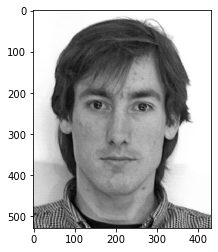

In [122]:
# example of bw picture
exm_img, exm_lbl = data[0], labels[0]
my_imshow(exm_img,exm_lbl)

In [123]:
# pixels are already scalled
print( torch.max(exm_img), torch.min(exm_img))

tensor(1.) tensor(0.)


In [124]:
class Transf:
    
    @staticmethod
    def compare_imgs(imgs, descs):
        list_len = len(imgs)
        
        fig, ax = plt.subplots(1, list_len,  figsize=(5*list_len,5))
        
        for i in range(list_len):
            ax[i].imshow(imgs[i].permute(1, 2, 0),cmap='gray')
            ax[i].set_title(descs[i])
            
       # fig.tight_layout(pad=3.0)
        
        
    @staticmethod
    def gamma_correcton(img,gamma=1.0):
        return  img**(1/gamma)
        
    @staticmethod
    def gamma_ilustration(gamma_list):
        x = np.arange(0., 1., 0.01)
        
        gammed_x = x
        gammed_x_list = []
        for gamma in gamma_list:
            gammed_x_list.append(x**(1/gamma))
            
        plt.figure(figsize=(6,6))
        plt.title('$\gamma$ correction')
        plt.xlabel("$I$",fontsize=18)
        plt.ylabel("$I^{1/\gamma}$",fontsize=18, rotation=0)
        plt.xticks(np.arange(0., 1.01, 0.1))
        plt.yticks(np.arange(0., 1.01, 0.1))
        
        for i in range(len(gamma_list)):
            plt.plot(x,gammed_x_list[i],label=f'$\gamma=${gamma_list[i]}')
        
        plt.legend(loc='best')
        plt.show()
        
    @staticmethod
    def __gaussian_filter(kernel_size, sigma):

        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size,kernel_size)

        y_grid = x_grid.t()
        
        xy_grid = torch.stack([y_grid, x_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        #print(xy_grid)

        gaussian_kernel = (1./(2.*np.pi*variance)) * \
                          torch.exp(
                              -torch.sum((xy_grid - mean)**2., dim = -1) / \
                              (2*variance)
                          )
        return gaussian_kernel
    
    
    @staticmethod
    def __faster_gaussian_filter(kernel_size, sigma):
    # this filter is faster because don't use "xy_grid"
        x_cord = torch.arange(kernel_size)
        
        mean = (kernel_size - 1)/2.
        variance = sigma**2.
        
        x_cord = x_cord - mean
        
        x_cord = torch.exp( -(x_cord*x_cord) / (2. * variance) )
        
        x_cord = x_cord.reshape((1,kernel_size)) # 1 x kernel_size
        y_cord = x_cord.reshape((kernel_size,1))          # kernel_size x 1
        
        # matrix multiplication in torch
        result = torch.matmul( y_cord, x_cord ) / (2. * np.pi * variance)
        
        return result
    
    @staticmethod
    def __DOG(kernel_size=5, sigma1=1.0, sigma2=1.0):
        gaussian_kernel1 = Transf.__faster_gaussian_filter(kernel_size, sigma1)                    
        gaussian_kernel2 = Transf.__faster_gaussian_filter(kernel_size, sigma2)
        
        return gaussian_kernel1 - gaussian_kernel2
    
    @staticmethod
    def __apply_filter(img, ft):
        img_shape = img.shape[1:]

        filter_size = ft.shape[0]
        padding = filter_size // 2

        padded_img = torch.cat([ torch.zeros(1, padding, img_shape[1] ), img, torch.zeros(1, padding, img_shape[1] )] , dim=1 )
        padded_img = torch.cat([ torch.zeros(1, img_shape[0]+2*padding, padding ), padded_img, torch.zeros(1, img_shape[0]+2*padding, padding )] , dim=2)

        res_img = torch.zeros( img_shape )

        # 3 dimensional tensor to 2 dimensional tensor
        padded_img = torch.reshape(padded_img, (padded_img.shape[1], padded_img.shape[2]) )

        for i in range(img_shape[0]):
            for j in range(img_shape[1]):
                res_img[i][j] = torch.sum(padded_img[i:i+filter_size,j:j+filter_size] * ft)

        # 2 dimensional tensor to 3 dimensional tensor
        res_img = torch.reshape(res_img, (1, *res_img.shape))
        
        return res_img
    
    @staticmethod
    def DOG_filtering(img, filter_size=5, sigma1=1.0, sigma2=1.0):
        DOG_filter = Transf.__DOG(filter_size, sigma1, sigma2)
        return Transf.__apply_filter(img, ft=DOG_filter)
    
    @staticmethod
    def __contrast_function(img, alpha, treshold=10.):
        dim1 = img.shape[1]
        dim2 = img.shape[2]
        
        tens_treshold = torch.tensor([treshold]).repeat(dim1 * dim2)
        img = img.view(dim1 *dim2)
        
        img = img / ( ( torch.mean(torch.where(torch.abs(img)<treshold ,torch.abs(img), tens_treshold )**alpha) )**(1.0/alpha) )
        
        return img.view(1, dim1, dim2)
    
    @staticmethod
    def contrast_equalization(img, alpha, treshold=10):
        return Transf.__contrast_function(img, alpha)
    
    @staticmethod
    def min_max_normalisation_of_tensor(img):
        img_min = torch.min(img)
        img_max = torch.max(img)
        
        divide_by = img_max - img_min
        
        return ( img - img_min ) / divide_by
    
    @staticmethod
    def process_img(img, gamma, kernel_size, sgm1, sgm2, alpha, treshold=10):
        img = Transf.gamma_correcton(img, gamma)
        img = Transf.DOG_filtering(img, kernel_size, sgm1, sgm2)
        img = Transf.contrast_equalization(img, alpha, treshold)
        
        return Transf.min_max_normalisation_of_tensor(img)

## 1) Gamma correction

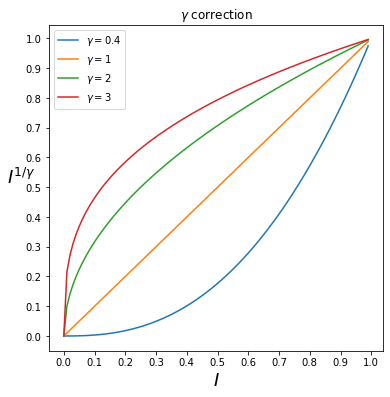

In [125]:
Transf.gamma_ilustration([0.4,1,2,3])

Class label:  0


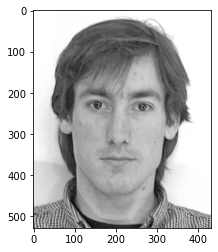

In [126]:
GAMMA = 1.4

gammed_img = Transf.gamma_correcton(exm_img, GAMMA)
my_imshow(gammed_img, exm_lbl)

In [127]:
pictures = [exm_img, gammed_img]
labels_of_pictures = ['original', 'gammed']

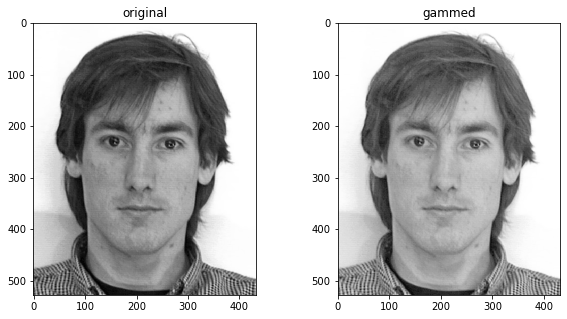

In [128]:
Transf.compare_imgs(pictures, labels_of_pictures)

## 2) Difference Of Gaussian

In [130]:
KERNEL_SIZE = 13
SIGMA1 = 1.
SIGMA2 = 2.

DOG_img = Transf.DOG_filtering(gammed_img, KERNEL_SIZE, SIGMA1, SIGMA2)

Class label:  0


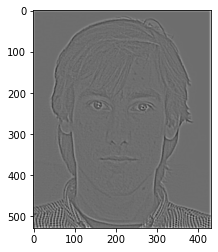

In [132]:
my_imshow(DOG_img, exm_lbl)

In [133]:
pictures.append(DOG_img)
labels_of_pictures.append('DOG_filtered')

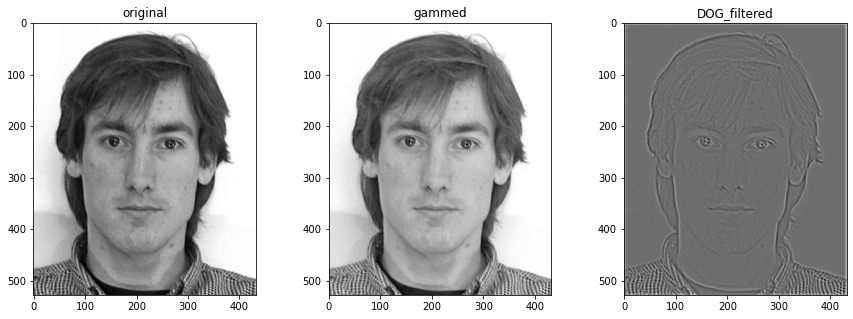

In [134]:
Transf.compare_imgs(pictures, labels_of_pictures)

## 3) Contrast equalization

Purpose is to equalise contrast on some part of picture, such as small dark
regions such as nostrils, garbage at the image borders, etc..

In [135]:
CONTRAST_CONST = 0.1

contrasted_img = Transf.contrast_equalization(DOG_img, CONTRAST_CONST)
contrasted_img = Transf.min_max_normalisation_of_tensor(contrasted_img)

In [136]:
pictures.append(contrasted_img)
labels_of_pictures.append('contrasted')

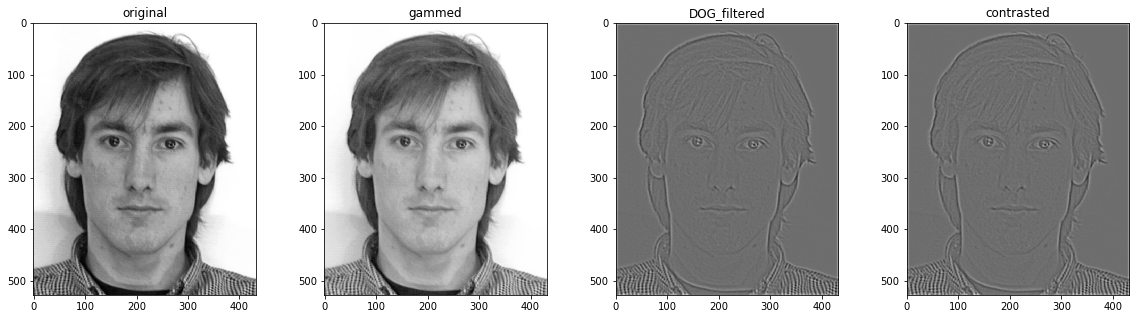

In [137]:
Transf.compare_imgs(pictures, labels_of_pictures)

## 4) Saving processed pictures

In [138]:
GAMMA = 1.4

KERNEL_SIZE = 13
SIGMA1 = 1.
SIGMA2 = 2.

CONTRAST_CONST = 0.1

In [139]:
'''
# saving all processed pictures

prev_lbl = -1
count = 1

if os.path.exists("processed_data") is True:
    shutil.rmtree('./processed_data')
    
os.mkdir("processed_data")


data_iter = iter(dataload)
for data_per_iteration in data_iter:

    data_label = data_per_iteration[0]
    batch_size = data_per_iteration[1]

    data =[dl[0] for dl in data_label]
    labels = [dl[1] for dl in data_label]
    
    for tmp_img, tmp_lbl in zip(data, labels):
        if prev_lbl == tmp_lbl:
            counter += 1
        else:
            counter=0
            prev_lbl = tmp_lbl
            os.mkdir("processed_data/p{}".format(prev_lbl))
        
        tmp_img = Transf.process_img(tmp_img, GAMMA, KERNEL_SIZE, SIGMA1, SIGMA2, CONTRAST_CONST)
        
# prevodimo sliku u PIL, kako bi uspesno mogli da je sacuvamo, jer torch po pravilu cuva 3 kanala
        pil_img = tt.ToPILImage()(tmp_img).convert('L')
        destination = "./processed_data/p{}/{}.png".format(prev_lbl, counter)

        pil_img.save(destination)
''' 

'\n# saving all processed pictures\n\nprev_lbl = -1\ncount = 1\n\nif os.path.exists("processed_data") is True:\n    shutil.rmtree(\'./processed_data\')\n    \nos.mkdir("processed_data")\n\n\ndata_iter = iter(dataload)\nfor data_per_iteration in data_iter:\n\n    data_label = data_per_iteration[0]\n    batch_size = data_per_iteration[1]\n\n    data =[dl[0] for dl in data_label]\n    labels = [dl[1] for dl in data_label]\n    \n    for tmp_img, tmp_lbl in zip(data, labels):\n        if prev_lbl == tmp_lbl:\n            counter += 1\n        else:\n            counter=0\n            prev_lbl = tmp_lbl\n            os.mkdir("processed_data/p{}".format(prev_lbl))\n        \n        tmp_img = Transf.process_img(tmp_img, GAMMA, KERNEL_SIZE, SIGMA1, SIGMA2, CONTRAST_CONST)\n        \n# prevodimo sliku u PIL, kako bi uspesno mogli da je sacuvamo, jer torch po pravilu cuva 3 kanala\n        pil_img = tt.ToPILImage()(tmp_img).convert(\'L\')\n        destination = "./processed_data/p{}/{}.png".for